In [57]:
import numpy as np
import scipy as sp
from numba import njit
from matplotlib import pyplot as plt


def plot_loss(x, y_pred, y_truth):

    diff = abs(y_truth - y_pred)
    losses = - np.log10(np.clip(diff, 1e-17, np.inf))

    plt.figure(figsize=(16, 8))
    plt.title('Абсолютная погрешность', fontsize=16)
    
    for i in range(4):
        plt.plot(x, losses[:, i], label=f'y{i}')

    plt.legend(loc='best')
    plt.xlabel('x', fontsize=12)
    plt.ylabel('- log10(|y_pred - y_true|)', fontsize=12)

# Постановка задачи

Необходимо решить систему дифференциальных уравнений в области определения функции f.

$$ \frac{dy}{dx} = f(x, y) $$

При наличии начальных условий

$$y\left(x_{0}\right)=y_{0}$$

где в общем случае $y$ вектор функция $ y = (y^1, y^2, ..., y^n)$



# Явный метод Рунге
Воспользуемся разложением Тейлора в точке $x_i$ для вычисления значения функции в точке $x_{i+1}$

$$
y\left(x_{i+1}\right)=y\left(x_{i}\right)+h y^{\prime}\left(x_{i}\right)+\frac{h^{2}}{2} y^{\prime \prime}\left(x_{i}\right)+\ldots+\frac{h^{s}}{s !} y^{(s)}\left(x_{i}\right)
+\frac{h^{s+1}}{(s+1) !} y^{(s+1)}(\xi)\\ y\left(x_{i+1}\right) = 
y\left(x_{i}\right)+\triangle\left(x_{i}, y\left(x_{i}\right), h\right)
$$

Но так как вычисление $\triangle\left(x_{i}, y\left(x_{i}\right), h\right)$ проблематично в общем случае (нужно брать частные производные). Воспользуемся приближением, предложенным Рунге, Хойном и Куттом.

$$
\varphi(x, y(x), h)=\sum_{i=1}^{m} b_{i} k_{i}(h) \\
\text { где } \quad k_{i}(h)=h f\left(x+h c_{i}, y(x)+\sum_{j=1}^{i-1} a_{i j} k_{j}\right) \quad i=1,2, \ldots, m
$$

И будем искать решение в виде 
$$
y(x+h) \approx y(x)+\sum_{i=1}^{m} b_{i} k_{i}(h)
$$

Коэффициенты метода будем находить из условия равенства порядка метода числу s. Для этого возьмем методическую погрешность метода $\Psi(h)$.

$$
\Psi(h)=y(x+h)-y(x)-\sum_{i=1}^{m} b_{i} k_{i}(h)
$$

Раскладываем в ряд $\Psi(h)$ в точке 0

$$
\Psi(h)=\sum_{i=0}^{s} \frac{\Psi^{(i)}(0)}{i !} h^{i}+\frac{\Psi^{(s+1)}(\theta h)}{(s+1) !} h^{s+1}
$$

И находим коэффициенты из равенств 0 производных $\Psi(h)$ в точке 0 (Если это можно сделать). При разных m мы имеем двух этапный метод Рунге

In [58]:
@njit
def f(x, y, A=1, B=1, C=1):
    values_f = np.array([2 * x * y[1] ** (1/B) * y[3],
                         2 * B * x * np.exp(B / C * (y[2] - A)) * y[3],
                         2 * C * x * y[3],
                         - 2 * x * np.log(y[0])], dtype=np.float64)
    return values_f

In [59]:
def solution(x, A=1, B=1, C=1):
    values_sol = np.array([np.exp(np.sin(x ** 2)),
                         np.exp(B * np.sin(x ** 2)),
                         np.sin(x ** 2) * C + A,
                         np.cos(x ** 2)])
    return values_sol

In [60]:
@njit
def _runge_method(f, x0, y0, a21, c2, b2, b1, h):
    """ Two-stage one-step runge method for solving differential equations """
    
    k1 = h * f(x0, y0)
    k2 = h * f(x0 + c2 * h, y0 + a21 * k1 * h)
    
    y = y0 + b1 * k1 + b2 * k2
    
    return y

@njit(fastmath=True)
def runge_method(f, x0, y0, x_end, c2, h):
    """ Two-stage runge method for solving differential equations """
    
    n_polints = int((x_end - x0)/h)
    params = [c2, c2, 1/2/c2, 1-1/2/c2, h]
    
    y = np.zeros(len(y0), dtype=np.float64) + y0
    y_on_each_step = np.zeros((n_polints, len(y)))
    
    for i, x in enumerate(np.linspace(x0, x_end, n_polints)):
        y = _runge_method(f, x, y, params[0], params[1], 
                          params[2], params[3], params[4])
        
        y_on_each_step[i] = y
    
    return np.linspace(x0, x_end, n_polints), y_on_each_step

In [64]:
A, c2 = 1, 1/3
h = 1e-6

x0, y0 = 0, np.array([1, 1, A, 1])
x_end = 5

x, y_pred = runge_method(f, x0, y0, c2=c2, h=h, x_end=x_end)

In [65]:
y_truth = np.array([solution(x) for x in x])

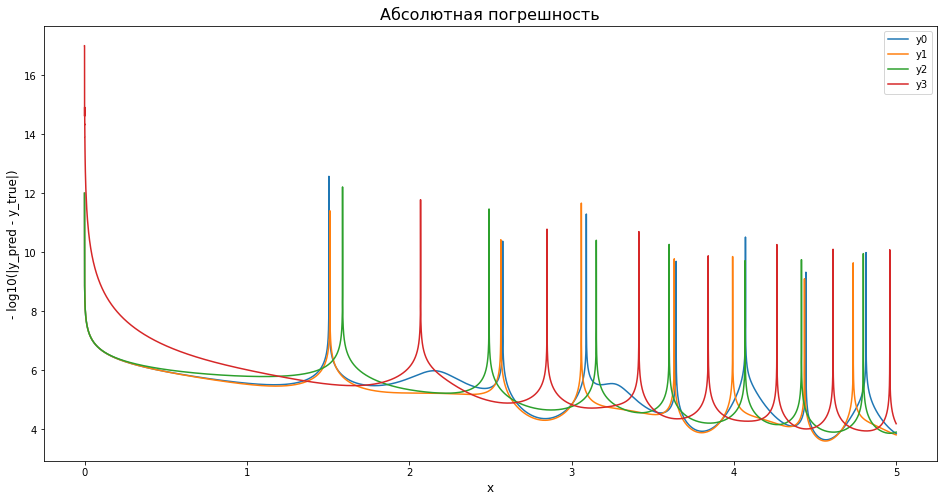

In [66]:
plot_loss(x, y_pred, y_truth)